# Analyze OFF Category Frequencies

Overall Goal: Find food categories that are suitable for search autosuggestion. Use most popular categories as input for manual curation.

Hypothesis: Categories with many products are more popular, i.e. more frequently bought and/or more diverse product palette/manufaturers.

https://world.openfoodfacts.org/categories.json&page=10&page_size=10

In [1]:
from IPython.display import Image
from networkx.drawing.nx_agraph import to_agraph
from openfoodfacts.taxonomy import get_taxonomy, Taxonomy, TaxonomyNode
from urllib.request import urlopen, urlretrieve
from urllib.parse import urlencode
from pathlib import Path
import io
import pandas as pd
import networkx as nx
import json
import time

## Download Category Pages

- contains number of products per category

In [2]:
API_URL = "https://world.openfoodfacts.org/categories.json?"

def download_cat_page(page: int):
    params = {"page_size": 1000, "page": page}

    out_file = f"./off_cat_frequencies_page{page}.json"

    # skip download if data has been downloaded before
    if not Path(out_file).exists():
        print(f"LOADING: cat page {page}")
        urlretrieve(API_URL + urlencode(params), out_file)
    else:
        print(f"SKIP: {out_file} already exists")

In [3]:
%%time
for page in range(1,9):
    time.sleep(0.5)
    download_cat_page(page)

SKIP: ./off_cat_frequencies_page1.json already exists
SKIP: ./off_cat_frequencies_page2.json already exists
SKIP: ./off_cat_frequencies_page3.json already exists
SKIP: ./off_cat_frequencies_page4.json already exists
SKIP: ./off_cat_frequencies_page5.json already exists
SKIP: ./off_cat_frequencies_page6.json already exists
SKIP: ./off_cat_frequencies_page7.json already exists
SKIP: ./off_cat_frequencies_page8.json already exists
CPU times: user 134 ms, sys: 5.58 ms, total: 139 ms
Wall time: 4.03 s


## Combine JSON files in DataFrame

In [4]:
def load_cat_as_df(page: int):
    file = f"./off_cat_frequencies_page{page}.json"
    
    # load json file
    with open(file) as f:
        data = json.load(f)

    # create data frame from product information
    return (pd.DataFrame(data['tags'])
              .drop(['url', 'sameAs'], axis=1)
              .set_index('id')
           )

In [5]:
all_dfs = [load_cat_as_df(page) for page in range(1,9)]
cat_df = pd.concat(all_dfs)
cat_df

,known,name,products
id,,,
en:plant-based-foods-and-beverages,1,Plant-based foods and beverages,452890
en:plant-based-foods,1,Plant-based foods,393287
en:snacks,1,Snacks,275343
en:sweet-snacks,1,Sweet snacks,202380
en:beverages,1,Beverages,174087
...,...,...,...
de:getränkesirup,0,de:getränkesirup,9
en:orange-based-mixed-fruits-multivitamin-juice,1,Orange based mixed fruits multivitamin juice,9
fr:desserts-vanille,0,fr:desserts-vanille,9


## Exploratory Data Analysis

### Categories not in Taxonomy

In [6]:
cat_df.known.value_counts()

known
1    5616
0    2384
Name: count, dtype: int64

In [7]:
cat_df[lambda x: x.known == 0]

,known,name,products
id,,,
en:groceries,0,groceries,72006
en:salted-snacks,0,salted-snacks,7638
en:salads,0,salads,4537
en:baking-decorations,0,baking-decorations,2742
en:bars-covered-with-chocolate,0,bars-covered-with-chocolate,2335
...,...,...,...
fr:pains-au-levain,0,fr:pains-au-levain,9
es:sin-gluten,0,es:sin-gluten,9
de:getränkesirup,0,de:getränkesirup,9


### Countries

In [8]:
cat_df.index.str[:2].value_counts()

id
en    5877
fr    1351
de     246
es     222
it     194
pt      20
ru      18
ro      13
pl      13
nl       9
bg       5
sv       4
ca       3
cs       3
sl       3
et       3
hr       2
hu       2
ja       2
nb       2
da       2
af       1
gr       1
th       1
xx       1
fi       1
lt       1
Name: count, dtype: int64

## Augment with Taxonomy Data

### Load Taxonomy

In [9]:
categories: Taxonomy = get_taxonomy("category")
print(f"categories: {len(categories):,}")

categories: 13,404


### Add Localized German Category Name

In [10]:
lang = 'de'
cat_df[f'name_{lang}'] = cat_df.index.map(lambda x: categories[x].names.get(lang) if categories[x] else None)
cat_df

,known,name,products,name_de
id,,,,
en:plant-based-foods-and-beverages,1,Plant-based foods and beverages,452890,Pflanzliche Lebensmittel und Getränke
en:plant-based-foods,1,Plant-based foods,393287,Pflanzliche Lebensmittel
en:snacks,1,Snacks,275343,Imbiss
en:sweet-snacks,1,Sweet snacks,202380,Süßer Snack
en:beverages,1,Beverages,174087,Getränke
...,...,...,...,...
de:getränkesirup,0,de:getränkesirup,9,None
en:orange-based-mixed-fruits-multivitamin-juice,1,Orange based mixed fruits multivitamin juice,9,None
fr:desserts-vanille,0,fr:desserts-vanille,9,None


### Add parents and parent/child counts

In [11]:
cat_df['parents'] = cat_df.index.map(lambda x: '|'.join([p.id for p in categories[x].parents]) if categories[x] else None)
cat_df['num_parents'] = cat_df.index.map(lambda x: len(categories[x].parents) if categories[x] else -1)
cat_df['num_children'] = cat_df.index.map(lambda x: len(categories[x].children) if categories[x] else -1)
cat_df

,known,name,products,name_de,parents,num_parents,num_children
id,,,,,,,
en:plant-based-foods-and-beverages,1,Plant-based foods and beverages,452890,Pflanzliche Lebensmittel und Getränke,,0,4
en:plant-based-foods,1,Plant-based foods,393287,Pflanzliche Lebensmittel,en:plant-based-foods-and-beverages,1,52
en:snacks,1,Snacks,275343,Imbiss,,0,5
en:sweet-snacks,1,Sweet snacks,202380,Süßer Snack,en:snacks,1,9
en:beverages,1,Beverages,174087,Getränke,en:beverages-and-beverages-preparations,1,22
...,...,...,...,...,...,...,...
de:getränkesirup,0,de:getränkesirup,9,None,None,-1,-1
en:orange-based-mixed-fruits-multivitamin-juice,1,Orange based mixed fruits multivitamin juice,9,None,en:multifruit-juices,1,0
fr:desserts-vanille,0,fr:desserts-vanille,9,None,None,-1,-1


### Parent Analytics

- number of parents

In [12]:
cat_df.num_parents.value_counts()

num_parents
 1    4286
-1    2411
 2    1160
 3      83
 0      55
 4       5
Name: count, dtype: int64

- most popular parent

In [13]:
cat_df.parents.value_counts()

parents
en:sauces                                   66
en:pastas                                   60
en:wines-from-france                        58
en:cheeses                                  56
                                            55
                                            ..
en:haddock|en:smoked-fishes                  1
en:burrata|en:cow-cheeses                    1
en:open-pet-food-facts                       1
en:caramel-chocolates|en:dark-chocolates     1
en:rye-and-wheat-breads                      1
Name: count, Length: 2227, dtype: int64

- number of children

In [14]:
cat_df.num_children.value_counts()

num_children
 0      3465
-1      2411
 1       606
 2       433
 3       252
        ... 
 33        1
 96        1
 94        1
 60        1
 129       1
Name: count, Length: 66, dtype: int64

### Root Categories

Categories without parents. They are very generic.

In [15]:
cat_df[lambda x: x.num_parents == 0]

,known,name,products,name_de,parents,num_parents,num_children
id,,,,,,,
en:plant-based-foods-and-beverages,1,Plant-based foods and beverages,452890,Pflanzliche Lebensmittel und Getränke,,0,4
en:snacks,1,Snacks,275343,Imbiss,,0,5
en:dairies,1,Dairies,143798,Milchprodukte,,0,16
en:meats-and-their-products,1,Meats and their products,126902,Auf Fleisch basierende Lebensmittel,,0,35
en:fermented-foods,1,Fermented foods,111739,Fermentierte Lebensmittel,,0,3
en:condiments,1,Condiments,106331,Gewürzmittel,,0,20
en:desserts,1,Desserts,87471,Desserts,,0,48
en:meals,1,Meals,85438,Fertiggerichte,,0,95
en:spreads,1,Spreads,77442,Brotaufstriche,,0,7


### No Children

In [16]:
cat_df[lambda x: x.num_children == 0]

,known,name,products,name_de,parents,num_parents,num_children
id,,,,,,,
en:sweetened-beverages,1,Sweetened beverages,11144,Gezuckerte Getränke,en:beverages,1,0
en:extra-virgin-olive-oils,1,Extra-virgin olive oils,10141,Native Olivenöle Extra,en:olive-oils,1,0
en:virgin-olive-oils,1,Virgin olive oils,9357,Native Olivenöle,en:olive-oils,1,0
en:protein-powders,1,Protein powders,5209,Proteinpulver,en:bodybuilding-supplements,1,0
en:open-beauty-facts,1,Open Beauty Facts,4725,None,en:non-food-products,1,0
...,...,...,...,...,...,...,...
en:shea-butter,1,Shea butter,9,Sheabutter,en:vegetable-fats,1,0
en:darnitsky-bread,1,Darnitsky bread,9,None,en:rye-and-wheat-breads,1,0
en:orange-blossom,1,Orange blossom,9,Orangenblüte,en:herbal-teas,1,0


### Many Children

In [17]:
cat_df[lambda x: x.num_children >20]

,known,name,products,name_de,parents,num_parents,num_children
id,,,,,,,
en:plant-based-foods,1,Plant-based foods,393287,Pflanzliche Lebensmittel,en:plant-based-foods-and-beverages,1,52
en:beverages,1,Beverages,174087,Getränke,en:beverages-and-beverages-preparations,1,22
en:meats-and-their-products,1,Meats and their products,126902,Auf Fleisch basierende Lebensmittel,,0,35
en:meats,1,Meats,98649,Fleisch,en:meats-and-their-products,1,31
en:desserts,1,Desserts,87471,Desserts,,0,48
...,...,...,...,...,...,...,...
en:spanish-fruits,1,Spanish fruits,15,None,en:fruits,1,23
en:wines-from-austria,1,Wines from Austria,15,Weine aus Österreich,en:wines,1,31
fr:macon,1,fr:Mâcon,13,None,en:maconnais-wines|en:red-wines|en:rose-wines|...,4,27


### Categories with Stopwords

Stopwords: with

In [18]:
cat_df[cat_df.index.str.contains("with")].index

Index(['en:meals-with-meat', 'en:fermented-dairy-desserts-with-fruits',
       'en:meals-with-fish', 'en:meals-with-chicken',
       'en:soft-cheeses-with-bloomy-rind', 'en:products-without-gluten',
       'en:bars-covered-with-chocolate', 'en:cereals-with-fruits',
       'en:mueslis-with-fruits', 'en:chocolates-with-hazelnuts',
       ...
       'en:bircher-style-sugar-free-muesli-flakes-with-fruits',
       'en:baguette-sandwiches-with-and-chicken-and-vegetables-and-mayonnaise',
       'en:profiteroles-with-custard-and-chocolate-sauce-refrigerated',
       'en:instant-noodles-with-beef-flavour',
       'en:white-rice-cooked-with-vegetables-and-meat',
       'en:frozen-dessert-ice-cream-with-meringue', 'en:pasta-with-beef',
       'en:easy-to-spread-unsalted-butter-with-82-fat',
       'en:partially-skimmed-chocolate-flavoured-milk-with-sugar-fortified-with-vitamins-and-chemicals-elements',
       'en:dark-chocolate-bar-filled-with-praline'],
      dtype='object', name='id', length=46

## Graph Visualization

In [19]:
def add_subgraph(G, cat: TaxonomyNode, max_depth: int = -1):
    '''Add a taxonomy node and all it's children to a graph.'''
    if max_depth == 0:
        return
    children = [n for n in cat.children if n.id in cat_df.index]
    count = cat_df.loc[cat.id].products
    for child in children:
        cnt = cat_df.loc[child.id].products
        #G.add_edge(f'"{cat.id} ({count:,})"', f'"{child.id} ({cnt:,})"')
        G.add_edge(f'{cat.id} ({count:,})', f'{child.id} ({cnt:,})')
        add_subgraph(G, child, max_depth-1)

def show_children(id):
    ids = [n.id for n in categories[id].children if n.id in cat_df.index]
    return cat_df.loc[ids].sort_values('products', ascending=False)

def plot_graph(cat: TaxonomyNode, max_depth: int = -1):
    G = nx.DiGraph()
    add_subgraph(G, cat, max_depth)
    
    # Convert NetworkX graph to a PyGraphviz AGraph
    A = to_agraph(G)
    
    # Set global graph attributes
    A.graph_attr['rankdir'] = 'LR'  # Left to right
    A.graph_attr['nodesep'] = '0.1'
    A.graph_attr['ranksep'] = '0.5'
    
    # Set node attributes
    for node in A.nodes():
        n = A.get_node(node)
        n.attr['shape'] = 'box'
        n.attr['height'] = '0'  # Remove top/bottom padding
        n.attr['fontsize'] = '10'
    
    # Draw the graph and store the result in an in-memory buffer
    A.layout(prog='dot')
    
    # Create an in-memory buffer
    buffer = io.BytesIO()
    A.draw(buffer, format='png')
    buffer.seek(0)
    
    return Image(data=buffer.read(), format='png')

import pydot
from networkx.drawing.nx_pydot import to_pydot

def plt_graph(G, png_file):
    # Convert NetworkX graph to a PyDot graph object
    P = to_pydot(G)
    
    P.set('rankdir', 'LR') # left to right
    P.set('nodesep', '0.1')
    P.set('ranksep', '0.5')
    
    for node in P.get_nodes():
        node.set_shape('box')
        node.set_height(0) # remove top/bottom padding
        node.set_fontsize(10)
    
    # visualize the graph
    P.write_png(png_file)

### Investigate Teas (and steaks)

In [20]:
cat_df[cat_df.index.str.contains("tea")].head(10)

,known,name,products,name_de,parents,num_parents,num_children
id,,,,,,,
en:teas,1,Teas,13569,Tees,en:hot-beverages|en:plant-based-beverages,2,11
en:tea-based-beverages,1,Tea-based beverages,6878,Teegetränke,en:beverages,1,4
en:herbal-teas,1,Herbal teas,6206,Kräutertees,en:beverage-preparations,1,47
en:iced-teas,1,Iced teas,4248,Eistees,en:tea-based-beverages,1,6
en:green-teas,1,Green teas,2501,Grüne Tees,en:teas,1,6
en:tea-bags,1,Tea bags,2361,Teebeutel,en:tea-leaves,1,0
en:steaks,1,Steaks,1619,Steaks,en:meats,1,5
en:beef-steaks,1,Beef steaks,1393,Rindersteaks,en:beef|en:steaks,2,2
en:ground-steaks,1,Ground steaks,1226,Hackfleischsteaks,en:steaks,1,4


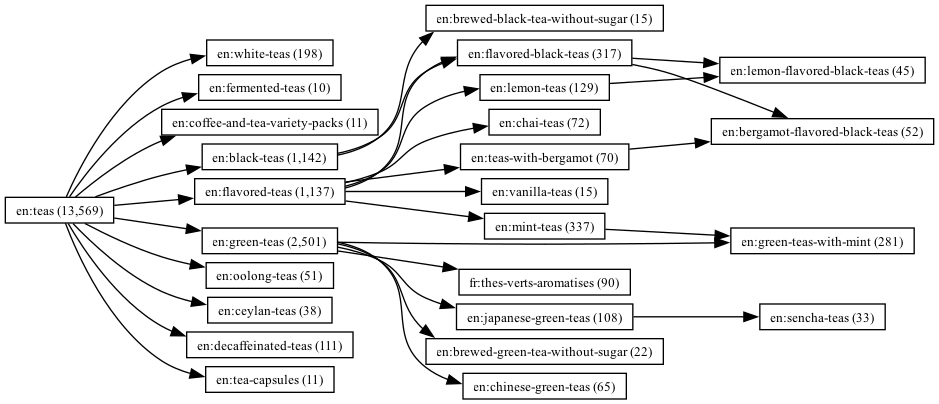

In [21]:
plot_graph(categories['en:teas'])

## Analyze Root Categories

In [22]:
show_children('en:plant-based-foods-and-beverages')

,known,name,products,name_de,parents,num_parents,num_children
id,,,,,,,
en:plant-based-foods,1,Plant-based foods,393287,Pflanzliche Lebensmittel,en:plant-based-foods-and-beverages,1,52
en:plant-based-beverages,1,Plant-based beverages,61329,Pflanzliche Getränke,en:beverages|en:plant-based-foods-and-beverages,2,14
en:dairy-substitutes,1,Dairy substitutes,13856,None,en:plant-based-foods-and-beverages,1,8
en:vegetable-based-foods-and-beverages,1,Vegetable-based foods and beverages,1419,Gemüse basierte Lebensmittel und Getränke,en:plant-based-foods-and-beverages,1,1


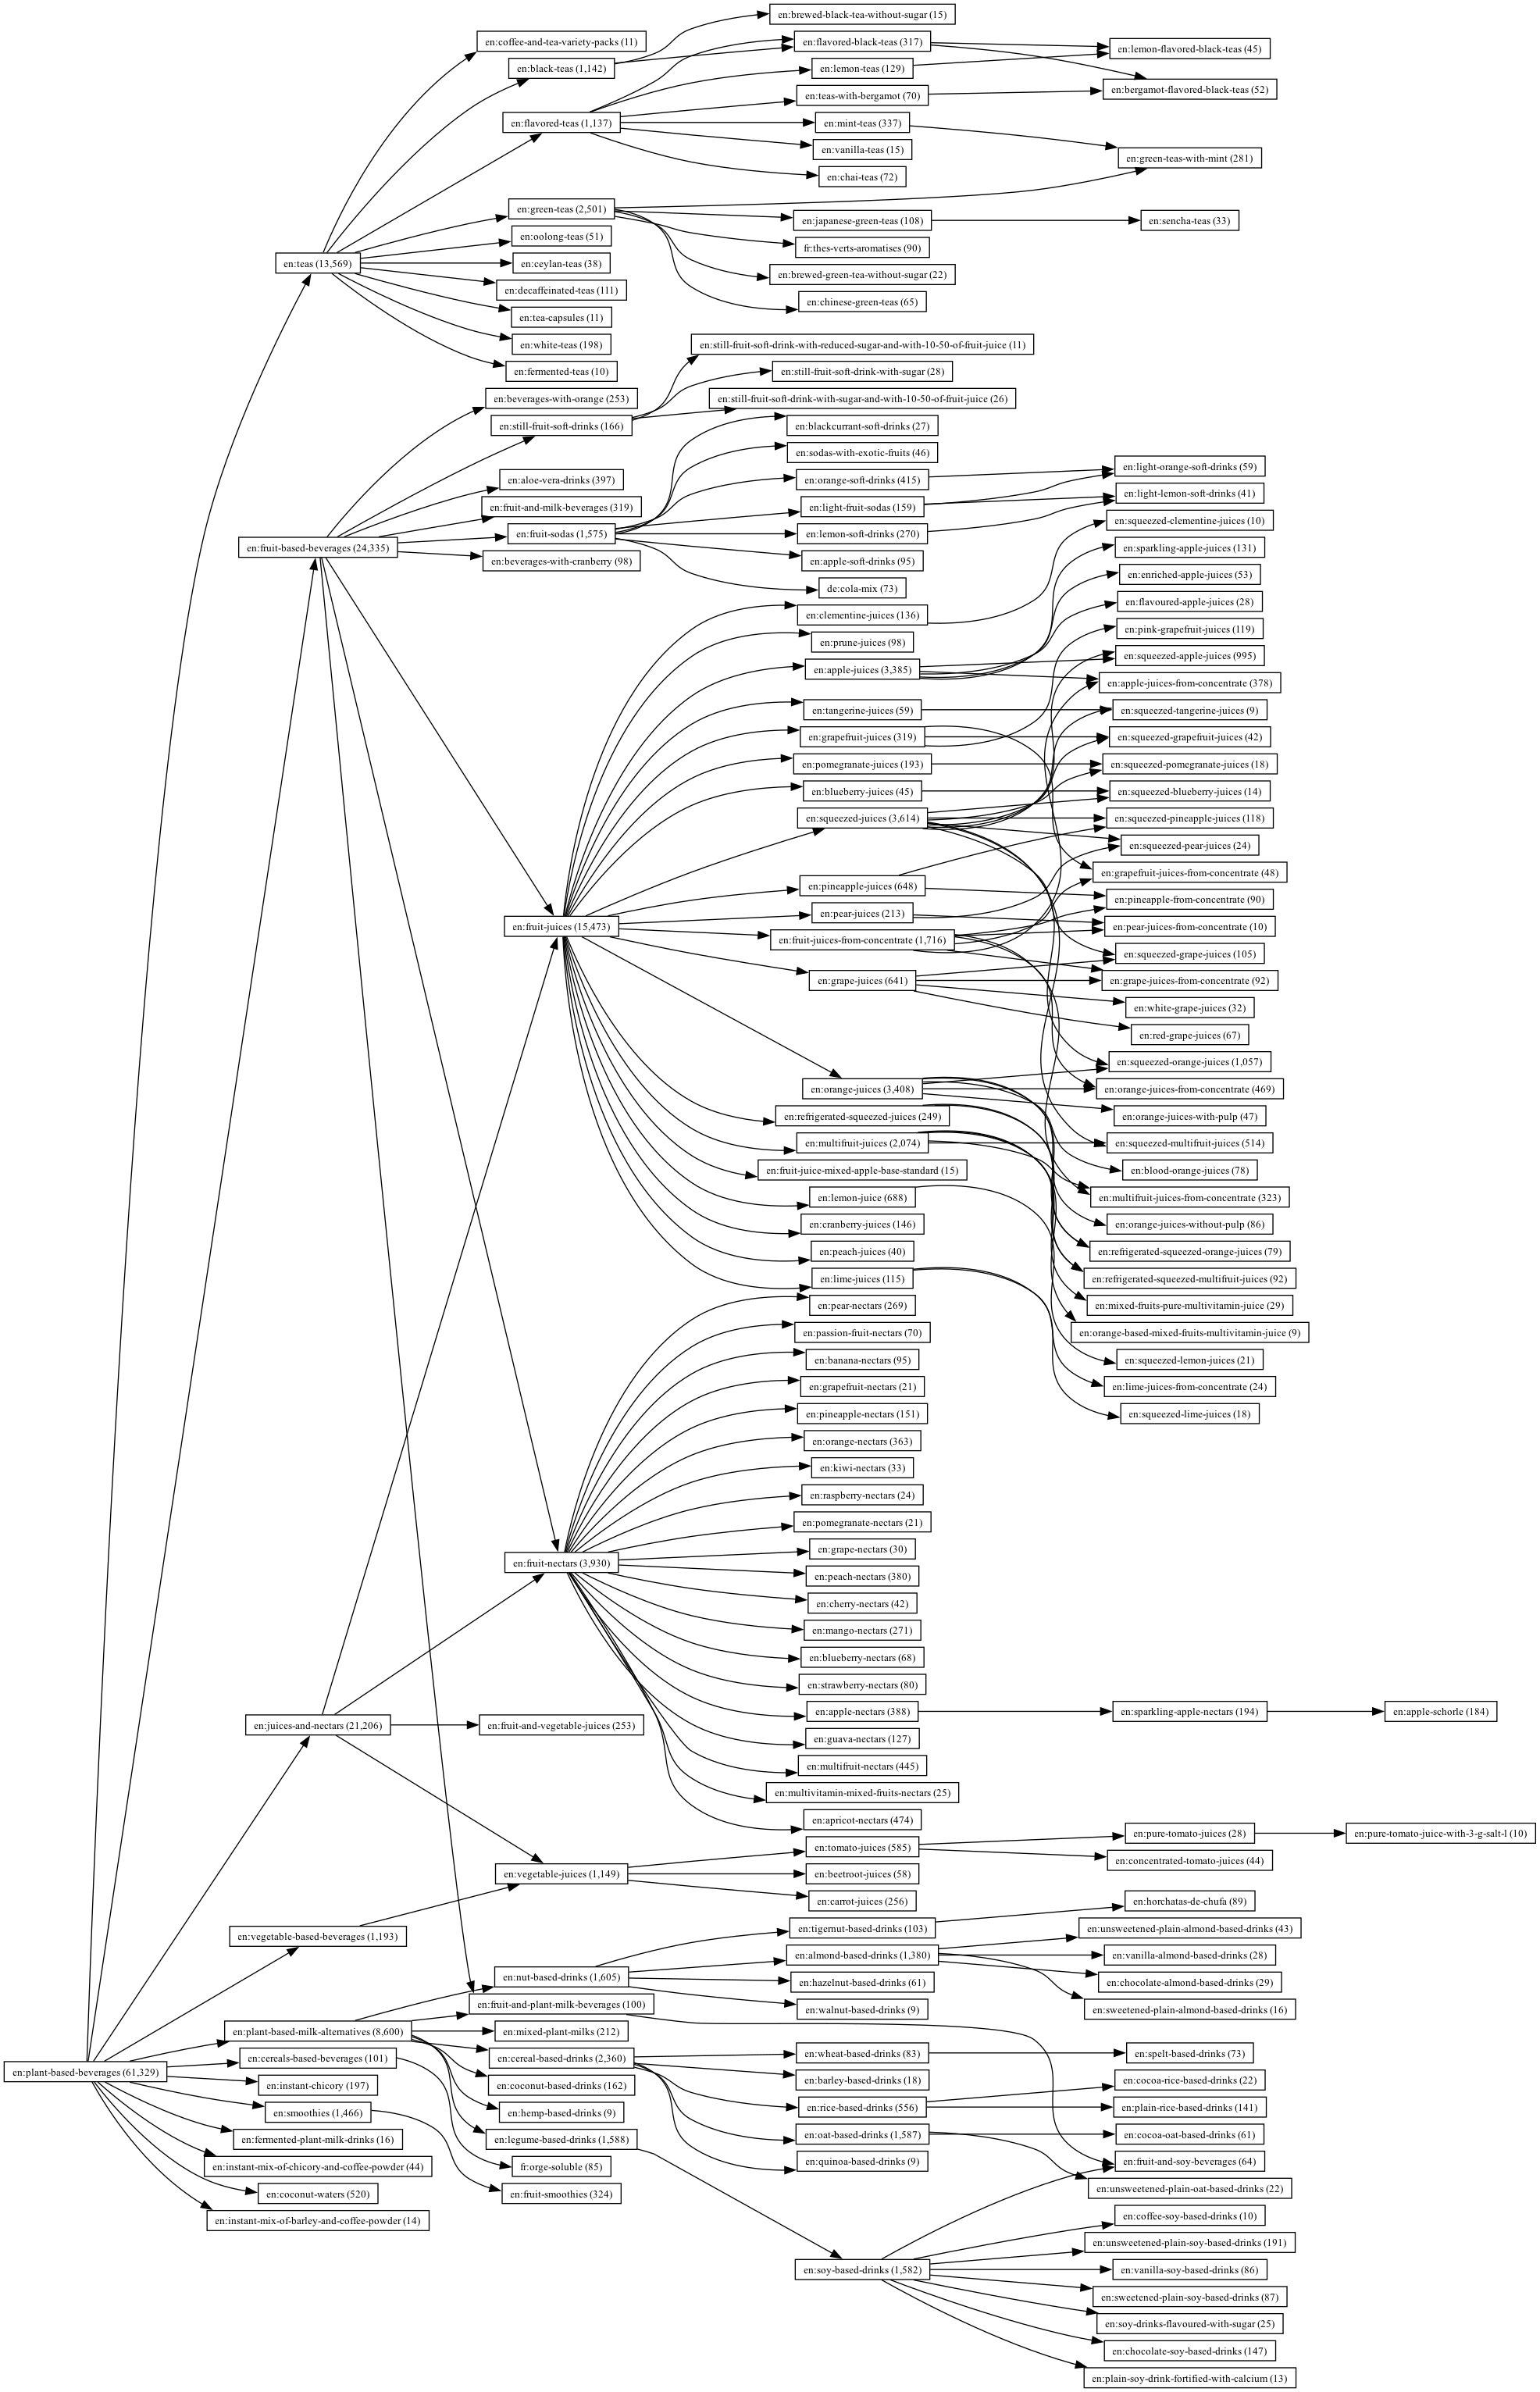

In [23]:
plot_graph(categories['en:plant-based-beverages'])

In [24]:
show_children('en:plant-based-beverages')

,known,name,products,name_de,parents,num_parents,num_children
id,,,,,,,
en:fruit-based-beverages,1,Fruit-based beverages,24335,Fruchtgetränke,en:plant-based-beverages,1,10
en:juices-and-nectars,1,Juices and nectars,21206,Säfte und Nektare,en:plant-based-beverages,1,4
en:teas,1,Teas,13569,Tees,en:hot-beverages|en:plant-based-beverages,2,11
en:plant-based-milk-alternatives,1,Plant-based milk alternatives,8600,Pflanzenmilch,en:milk-substitutes|en:plant-based-beverages,2,7
en:smoothies,1,Smoothies,1466,Smoothies,en:plant-based-beverages,1,2
en:vegetable-based-beverages,1,Vegetable-based beverages,1193,Gemüse basierte Getränke,en:plant-based-beverages|en:vegetable-based-fo...,2,1
en:coconut-waters,1,Coconut waters,520,Kokoswasser,en:plant-based-beverages,1,0
en:instant-chicory,1,Instant chicory,197,None,en:instant-coffee-substitutes|en:plant-based-b...,2,1
en:cereals-based-beverages,1,Cereals-based beverages,101,None,en:instant-beverages|en:plant-based-beverages,2,1


### Juices and Nectars

- ignore
  - refrigerated
  - from-concentrate (not healthy)
  - en:fruit-juice-mixed-apple-base-standard
- keep squeezed (Direktsaft)

In [25]:
show_children('en:fruit-juices')

,known,name,products,name_de,parents,num_parents,num_children
id,,,,,,,
en:squeezed-juices,1,Squeezed juices,3614,Direktsäfte,en:fruit-juices,1,11
en:orange-juices,1,Orange juices,3408,Orangensäfte,en:fruit-juices,1,7
en:apple-juices,1,Apple juices,3385,Apfelsaft,en:fruit-juices|en:unsweetened-beverages,2,6
en:multifruit-juices,1,Multifruit juices,2074,Multifruchtsäfte,en:fruit-juices,1,6
en:fruit-juices-from-concentrate,1,Fruit juices from concentrate,1716,Fruchtsäfte aus Konzentrat,en:fruit-juices,1,13
en:lemon-juice,1,Lemon juice,688,Zitronensäfte,en:fruit-juices,1,2
en:pineapple-juices,1,Pineapple juices,648,Ananassäfte,en:fruit-juices,1,3
en:grape-juices,1,Grape juices,641,Traubensäfte,en:fruit-juices,1,4
en:grapefruit-juices,1,Grapefruit juices,319,Grapefruitsäfte,en:fruit-juices,1,5


In [26]:
show_children('en:squeezed-juices')

,known,name,products,name_de,parents,num_parents,num_children
id,,,,,,,
en:squeezed-orange-juices,1,Squeezed orange juices,1057,Orangendirektsäfte,en:orange-juices|en:squeezed-juices,2,0
en:squeezed-apple-juices,1,Squeezed apple juices,995,Apfeldirektsäfte,en:apple-juices|en:squeezed-juices,2,0
en:squeezed-multifruit-juices,1,Squeezed multifruit juices,514,Multifruchtdirektsäfte,en:multifruit-juices|en:squeezed-juices,2,0
en:squeezed-pineapple-juices,1,Squeezed pineapple juices,118,Ananasdirektsäfte,en:pineapple-juices|en:squeezed-juices,2,0
en:squeezed-grape-juices,1,Squeezed grape juices,105,Traubendirektsäfte,en:grape-juices|en:squeezed-juices,2,0
en:squeezed-grapefruit-juices,1,Squeezed grapefruit juices,42,Grapefruitdirektsäfte,en:grapefruit-juices|en:squeezed-juices,2,0
en:squeezed-pear-juices,1,Squeezed pear juices,24,Birnendirektsäfte,en:pear-juices|en:squeezed-juices,2,0
en:squeezed-pomegranate-juices,1,Squeezed pomegranate juices,18,Granatapfeldirektsäfte,en:pomegranate-juices|en:squeezed-juices,2,0
en:squeezed-blueberry-juices,1,Squeezed blueberry juices,14,Heidelbeerdirektsäfte,en:blueberry-juices|en:squeezed-juices,2,0


In [27]:
show_children('en:fruit-juices-from-concentrate')

,known,name,products,name_de,parents,num_parents,num_children
id,,,,,,,
en:orange-juices-from-concentrate,1,Orange juices from concentrate,469,Orangensäfte aus Konzentrat,en:fruit-juices-from-concentrate|en:orange-juices,2,0
en:apple-juices-from-concentrate,1,Apple juices from concentrate,378,Apfelsäfte aus Konzentrat,en:apple-juices|en:fruit-juices-from-concentrate,2,0
en:multifruit-juices-from-concentrate,1,Multifruit juices from concentrate,323,Multifruchtsäfte aus Konzentrat,en:fruit-juices-from-concentrate|en:multifruit...,2,0
en:grape-juices-from-concentrate,1,Grape juices from concentrate,92,Traubensäfte aus Konzentrat,en:fruit-juices-from-concentrate|en:grape-juices,2,0
en:pineapple-from-concentrate,1,Pineapple from concentrate,90,Ananassäfte aus Konzentrat,en:fruit-juices-from-concentrate|en:pineapple-...,2,0
en:grapefruit-juices-from-concentrate,1,Grapefruit juices from concentrate,48,Grapefruitsäfte aus Konzentrat,en:fruit-juices-from-concentrate|en:grapefruit...,2,0
en:pear-juices-from-concentrate,1,Pear juices from concentrate,10,Birnensäfte aus Konzentrat,en:fruit-juices-from-concentrate|en:pear-juices,2,0


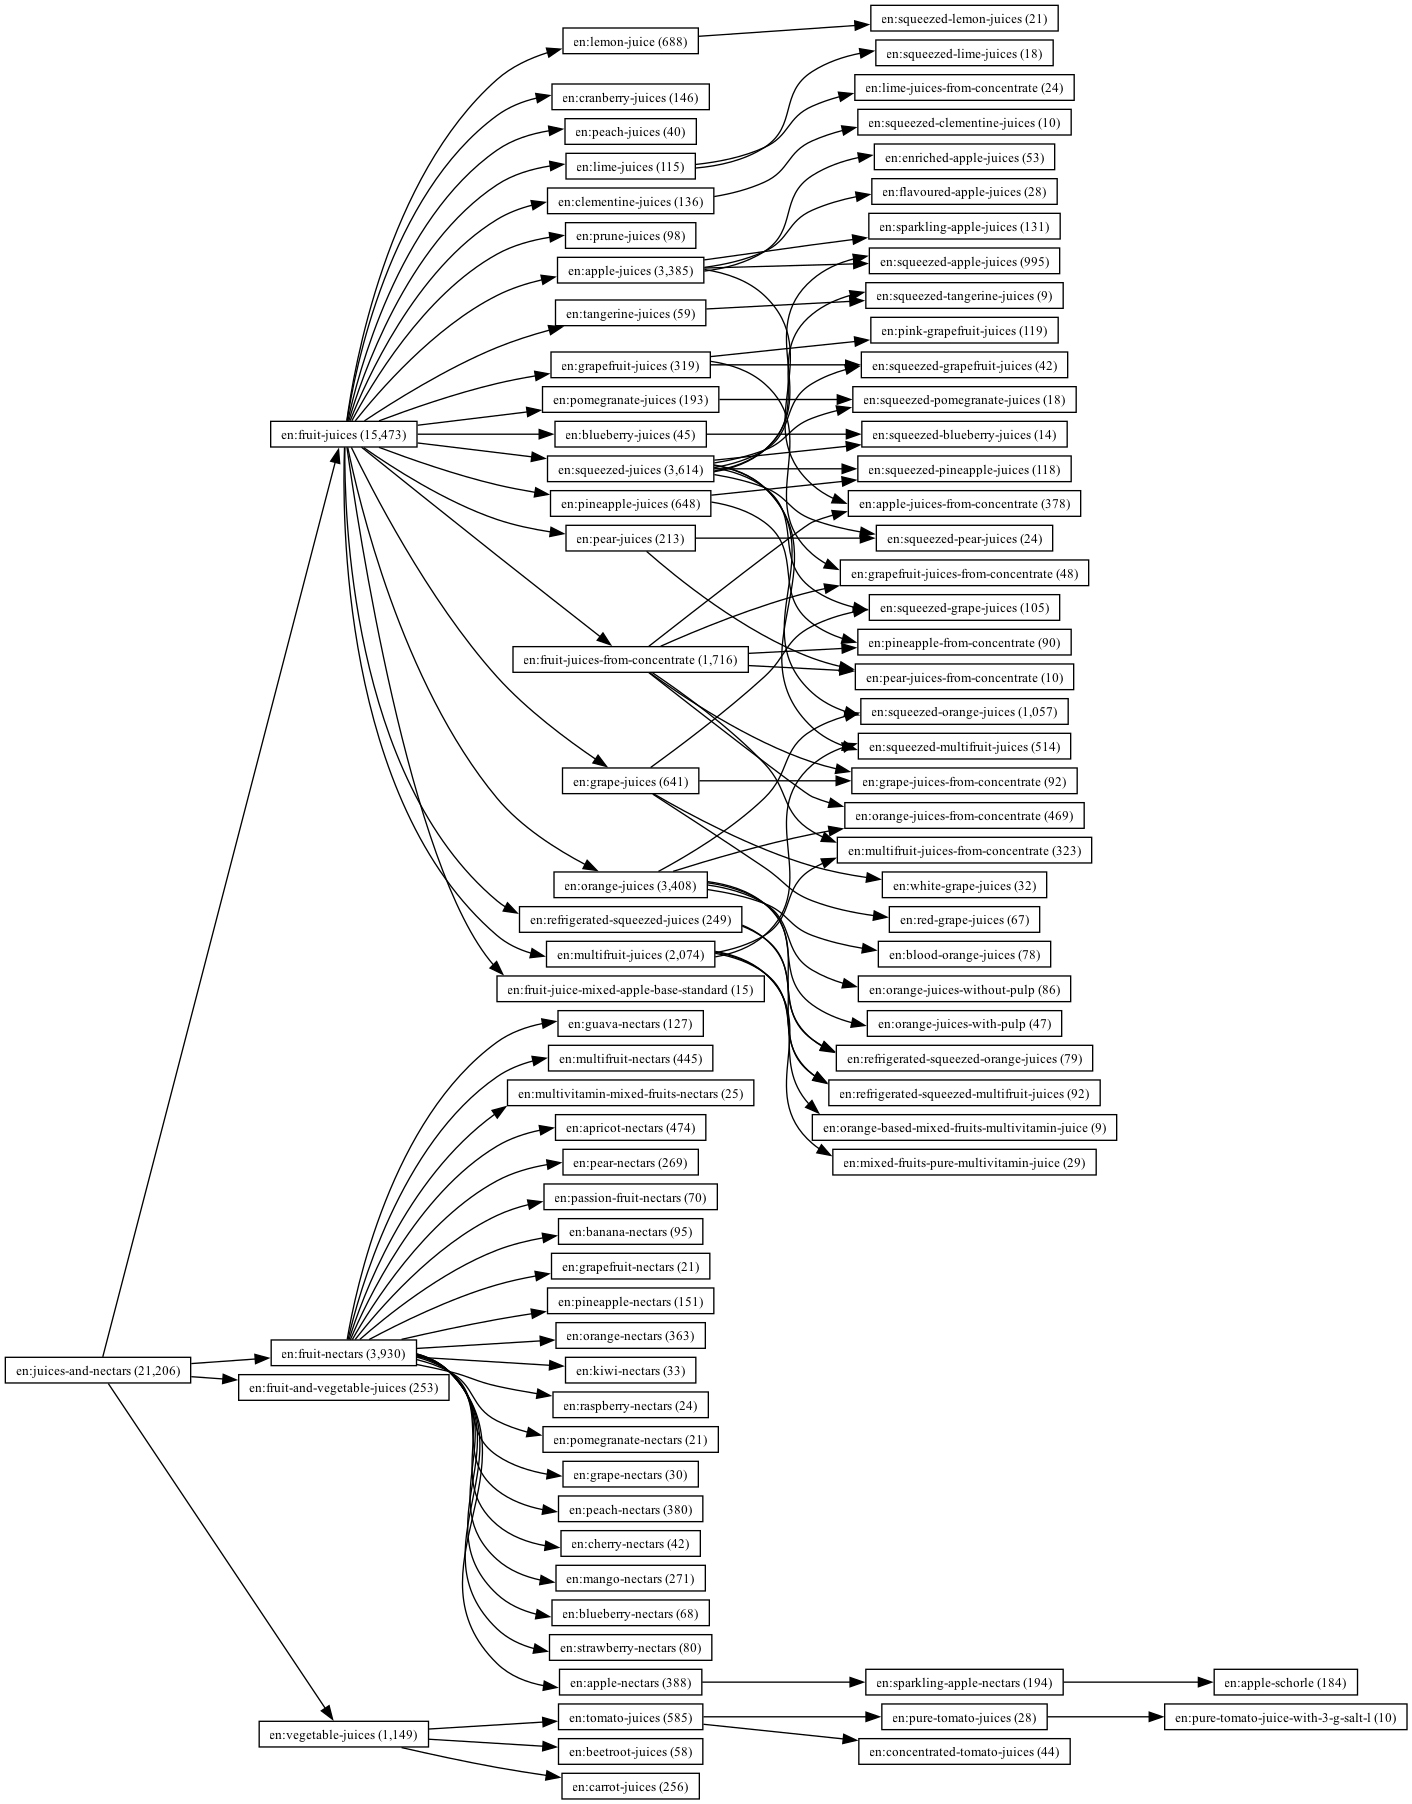

In [28]:
plot_graph(categories['en:juices-and-nectars'])

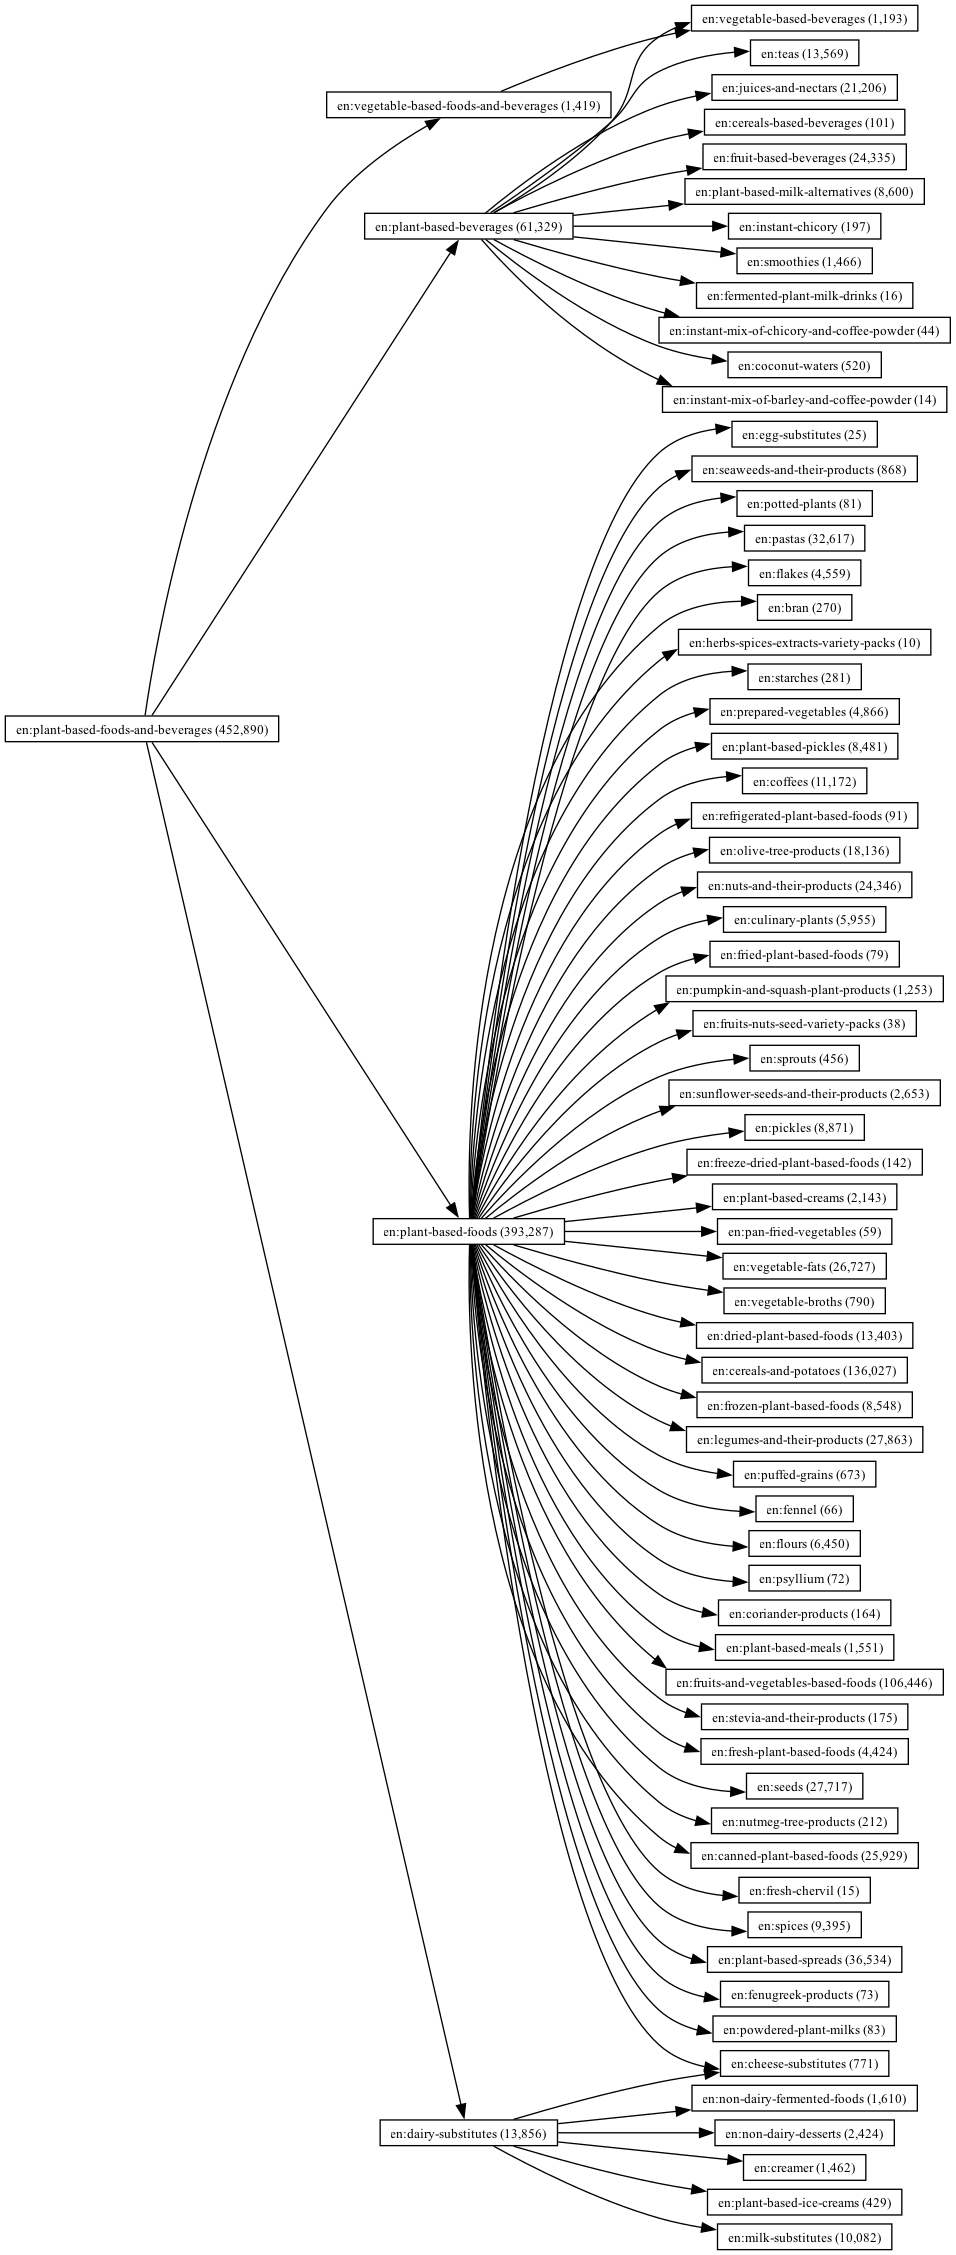

In [29]:
plot_graph(categories['en:plant-based-foods-and-beverages'], max_depth=2)

In [30]:
cat_df[cat_df.index.str.contains("chicory")].head(10)

,known,name,products,name_de,parents,num_parents,num_children
id,,,,,,,
en:instant-chicory,1,Instant chicory,197,None,en:instant-coffee-substitutes|en:plant-based-b...,2,1
en:chicory,0,chicory,136,None,None,-1,-1
en:instant-mix-of-chicory-and-coffee-powder,1,Instant mix of chicory and coffee powder,44,None,en:instant-beverages|en:plant-based-beverages,2,0


In [31]:
show_children('en:fruit-based-beverages')

,known,name,products,name_de,parents,num_parents,num_children
id,,,,,,,
en:fruit-juices,1,Fruit juices,15473,Fruchsäfte,en:fruit-based-beverages|en:juices-and-nectars,2,22
en:fruit-nectars,1,Fruit nectars,3930,Fruchtnektare,en:fruit-based-beverages|en:juices-and-nectars,2,24
en:fruit-sodas,1,Fruit sodas,1575,Fruchtlimonaden,en:fruit-based-beverages|en:sodas,2,7
en:aloe-vera-drinks,1,Aloe Vera drinks,397,Aloe Vera Saften,en:fruit-based-beverages,1,0
en:fruit-and-milk-beverages,1,Fruit and milk beverages,319,Frucht- und Milchsäfte,en:dairy-drinks|en:fruit-based-beverages,2,0
en:beverages-with-orange,1,Beverages with orange,253,Getränke mit Orange,en:fruit-based-beverages,1,0
en:still-fruit-soft-drinks,1,Still fruit soft drinks,166,None,en:fruit-based-beverages,1,5
en:fruit-and-plant-milk-beverages,1,Fruit and plant-milk beverages,100,None,en:fruit-based-beverages|en:plant-based-milk-a...,2,2
en:beverages-with-cranberry,1,Beverages with cranberry,98,Cranberry Getränke,en:fruit-based-beverages,1,0


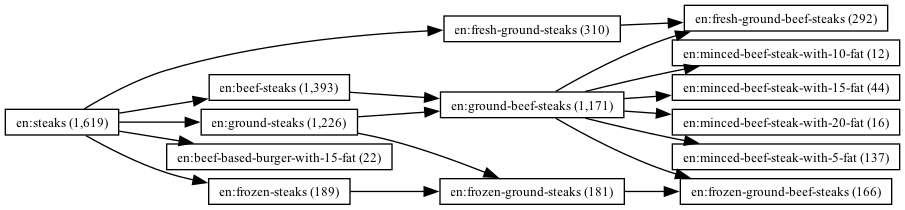

In [32]:
plot_graph(categories['en:steaks'])

In [33]:
#plot_graph(categories['en:desserts'])

In [34]:
show_children('en:teas')

,known,name,products,name_de,parents,num_parents,num_children
id,,,,,,,
en:green-teas,1,Green teas,2501,Grüne Tees,en:teas,1,6
en:black-teas,1,Black teas,1142,Schwarze Tees,en:teas,1,2
en:flavored-teas,1,Flavored teas,1137,Aromatisierte Tees,en:teas,1,6
en:white-teas,1,White teas,198,Weiße Tees,en:teas,1,3
en:decaffeinated-teas,1,Decaffeinated teas,111,Entkoffeinierte Tees,en:teas,1,0
en:oolong-teas,1,Oolong teas,51,Oolongtees,en:teas,1,0
en:ceylan-teas,1,Ceylan teas,38,None,en:teas,1,0
en:coffee-and-tea-variety-packs,1,Coffee and tea variety packs,11,Kaffee und Tee Mischpackungen,en:coffees|en:teas|en:variety-packs,3,0
en:tea-capsules,1,Tea capsules,11,Tee Kapseln,en:capsules|en:teas,2,0


In [35]:
show_children('en:green-teas')

,known,name,products,name_de,parents,num_parents,num_children
id,,,,,,,
en:green-teas-with-mint,1,Green teas with mint,281,Grüner Tees mit Minze,en:green-teas|en:mint-teas,2,0
en:japanese-green-teas,1,Japanese green teas,108,Japanische grüne Tees,en:green-teas,1,4
fr:thes-verts-aromatises,1,fr:Thés verts aromatisés,90,None,en:green-teas,1,0
en:chinese-green-teas,1,Chinese green teas,65,Chinesische grüne Tees,en:green-teas,1,2
en:brewed-green-tea-without-sugar,1,Brewed green tea without sugar,22,None,en:green-teas,1,0


In [36]:
show_children('en:japanese-green-teas')

,known,name,products,name_de,parents,num_parents,num_children
id,,,,,,,
en:sencha-teas,1,Sencha teas,33,Senchatees,en:japanese-green-teas,1,1


In [37]:
categories['en:sencha-teas'].children

[<TaxonomyNode en:fukuju-teas>]

In [38]:
show_children('en:flavored-teas')

,known,name,products,name_de,parents,num_parents,num_children
id,,,,,,,
en:mint-teas,1,Mint teas,337,Minztees,en:flavored-teas,1,1
en:flavored-black-teas,1,Flavored black teas,317,Aromatisierte schwarze Tees,en:black-teas|en:flavored-teas,2,2
en:lemon-teas,1,Lemon teas,129,Zitronentees,en:flavored-teas,1,1
en:chai-teas,1,Chaï teas,72,Chai,en:flavored-teas,1,0
en:teas-with-bergamot,1,Teas with bergamot,70,Tees mit Bergamotte,en:flavored-teas,1,1
en:vanilla-teas,1,Vanilla teas,15,Vanilletees,en:flavored-teas,1,0


In [39]:
show_children('en:flavored-black-teas')

,known,name,products,name_de,parents,num_parents,num_children
id,,,,,,,
en:bergamot-flavored-black-teas,1,Bergamot flavored black teas,52,None,en:flavored-black-teas|en:teas-with-bergamot,2,0
en:lemon-flavored-black-teas,1,Lemon flavored black teas,45,Schwarze Tees mit Zitronenaroma,en:flavored-black-teas|en:lemon-teas,2,0


## Save Categories

In [40]:
cat_df.to_csv("./off_category_freq.csv")